# Data Assimilation based on Lorenz '63 model

## Background: The Lorenz model
The Lorenz '63 model or Lorenz attractor model is a 3-dimensional coupled and nonlinear system of ODEs leading to chaotic behaviour. The model was introduced to describe the state of hydrodynamic systems like the earth atmosphere. For data assimilation this model is of particular interest since it is relatively easy, but still created chaotic oscillations quickly. In a data assimilation setting the model is hidden in the operator $M$.

Give some parameters $\sigma,\rho,\beta$ and initial conditions $x(0)=x_0, y(0)=y_0, z(0)=z_0$ the evolves as the solution of 
$$\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma(y-x)$$
$$\frac{\mathrm{d}y}{\mathrm{d}t} = x(\rho-x)$$
$$\frac{\mathrm{d}z}{\mathrm{d}t} = xy-\beta z$$

In [1]:
%load_ext autoreload
%autoreload 2

# Load general python modules
import importlib
import numpy as np
import matplotlib.pyplot as plt

# Load user modules
import lorenz63
import observation 
import ensemble 
import xyzplots
import filtering

# Ensuring reproducibility of statistical results
np.random.seed(0)


## Creating the Truth for Data Assimilation

The syntethic truth is construced with a given inital state.

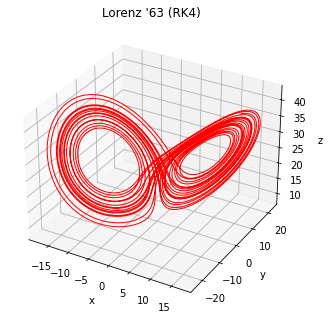

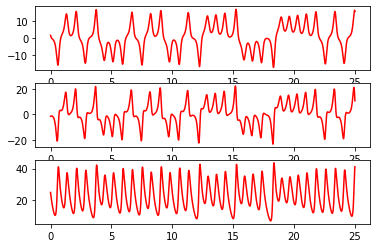

In [2]:
#import lorenz63
#importlib.reload(lorenz63)

lorenz63_params_model  = { "p" : 10.0, "r" : 28.0, "b" : 8.0/3.0 }
lorenz63_params_num    = { "tmax" : 25.0, "dt" : 1e-3 }
lorenz63_initial_state = [1.5,-1.5,25] # as in [Evensen: Data Assimilation, 2009]

lorenz63 = lorenz63.lorenz63( **lorenz63_params_model, **lorenz63_params_num )
lorenz63.setInitialState( lorenz63_initial_state )
lorenz63.simulate()
lorenz63.plot3D()
lorenz63.plot()


## Observing the True State

A observation is $Y = H(\Phi) + \epsilon_H$ where $H$ is the linear observation operator and $\epsilon_H\sim\mathcal{N}(0,1)$ is observational noise. The observation operator $H$ is constructed such that the specified components of $(x,y,z)$ are observed directly.

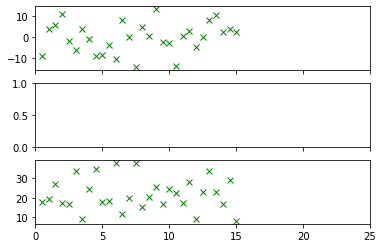

In [3]:
#import observation
#importlib.reload(observation)

obs_params = { "dt" : 0.5, "tmax" : 15.0 }
obs_variables = { "xobs" : True, "yobs" : False, "zobs" : True }

observation = observation.observation( **obs_params, **obs_variables )
observation.observe( lorenz63 )
observation.plot()

## Perturbing the Initial State

It is assumed that the initial condition is not knwon exactly. Therefore, the intial states are perturbed with $\mathcal{N}(0,5)$ around the given initial state from above.

NB! The true state is just a selected realisation among the possible inital states.

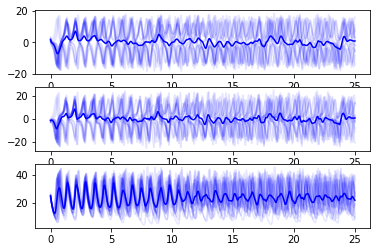

In [4]:
#import ensemble
#importlib.reload(ensemble)

ensemble = ensemble.ensemble(lorenz63,20)
ensemble.simulate()
ensemble.mean()
ensemble.plot()

#### Observation:
The perturbed system starts to form a bi-modal distribution, but quickly it gets chaotic and the entire state space is covered. The mean does not follow any pattern which is close to the truth anymore and just averages the entire state space.

## Plotting Truth, Observations and Perturbed Models

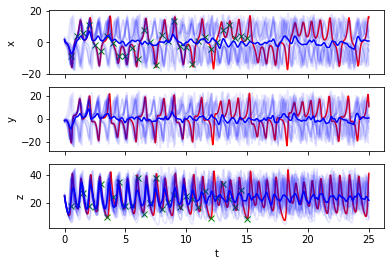

In [5]:
#import xyzplots
#importlib.reload(xyzplots)

xyzplots = xyzplots.xyzplots( lorenz63, observation, ensemble ) 
xyzplots.plot()

## Data Assimilation Problem 

Given the uncertain initial condition (which is the prior best guess without further knowledge) a filtering step is performed at every observation time. 

The data assimilation is governed by 
$$\Phi^n = M(\Phi^{n-1})$$
$$Y^n = H(\Phi^n) + \epsilon_H$$

NB! The model error $\epsilon_M$ is set to 0. 

## Ensemble Kalman Filtering 

The Ensemble Kalman Filter is implemented in two different versions:

1.  Stochastic EnKF as introduced by Geir Evensen
2.  Stochastic EnKF in a square-root formulation as stated in Vetra-Carvalho et al

The later implementation avoids to construct the big state-covariance matrix. Since the randomness is seeded in the implementation, the results are supposed to be exactly the same. 

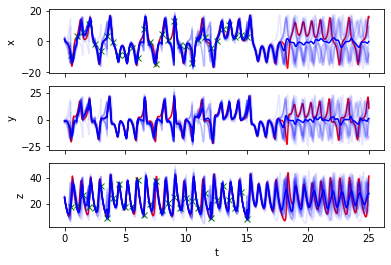

In [6]:
#import filtering
#importlib.reload(filtering)

np.random.seed(0)

filtering1 = filtering.filtering( ensemble, observation, "EnKF" )
filtering1.assimilate()
xyzplots.plot()

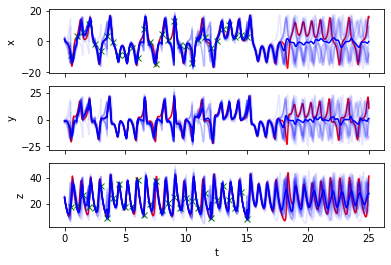

In [7]:
#import filtering 
#importlib.reload( filtering )

np.random.seed(0)

filtering2 = filtering.filtering( ensemble, observation, "EnKFSRF")
filtering2.assimilate()
xyzplots.plot()